### НИЯУ МИФИ. Лаботаторная работа #1. Полищук Максим, Б20-505

# Используемая система

```
Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         39 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  6
  On-line CPU(s) list:   0-5
Vendor ID:               GenuineIntel
  Model name:            12th Gen Intel(R) Core(TM) i5-12400F
    CPU family:          6
    Model:               151
    Thread(s) per core:  1
    Core(s) per socket:  6
    Socket(s):           1
    Stepping:            5
    BogoMIPS:            4992.00
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall n
                         x rdtscp lm constant_tsc rep_good nopl xtopology nonsto
                         p_tsc cpuid tsc_known_freq pni pclmulqdq vmx ssse3 cx16
                          pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx r
                         drand hypervisor lahf_lm abm 3dnowprefetch invpcid_sing
                         le tpr_shadow vnmi flexpriority vpid fsgsbase avx2 invp
                         cid rdseed clflushopt md_clear flush_l1d arch_capabilit
                         ies
Virtualization features: 
  Virtualization:        VT-x
  Hypervisor vendor:     KVM
  Virtualization type:   full
Caches (sum of all):     
  L1d:                   288 KiB (6 instances)
  L1i:                   192 KiB (6 instances)
  L2:                    7,5 MiB (6 instances)
  L3:                    108 MiB (6 instances)
NUMA:                    
  NUMA node(s):          1
  NUMA node0 CPU(s):     0-5
Vulnerabilities:         
  Itlb multihit:         Not affected
  L1tf:                  Not affected
  Mds:                   Not affected
  Meltdown:              Not affected
  Mmio stale data:       Not affected
  Retbleed:              Not affected
  Spec store bypass:     Vulnerable
  Spectre v1:            Mitigation; usercopy/swapgs barriers and __user pointer
                          sanitization
  Spectre v2:            Mitigation; Retpolines, STIBP disabled, RSB filling
  Srbds:                 Not affected
  Tsx async abort:       Not affected

```

# Код
```
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

#define STEP 10000

int main(int argc, char** argv)
{
    const int count = 10000000;     ///< Number of array elements
    const int random_seed = 31337; ///< RNG seed
    // const int target = 16;          ///< Number to look for

    int* array = 0;                 ///< The array we need to find the max in
    int  index = -1;                ///< The index of the element we need

    /* Initialize the RNG */
    srand(random_seed);
    double start, end;

    /* Generate the random array */
    array = (int*)malloc(count*sizeof(int));
    for(int i=0; i<count; i++) { array[i] = rand(); }

    char filename[50];
    sprintf(filename, "trace.txt");
    FILE *fp = fopen(filename, "w");
    if (fp == NULL) {
        printf("Can't open file\n");
        exit(1);
    }
    int threads = omp_get_max_threads();
    // printf("THREADS - %d", threads);
    // exit(1);

    for (int thread = 1; thread <= threads; thread++) {

        for (int ind = 0; ind < count; ind += STEP) {
            int target = array[ind];
            int ans = -1;
            int tmp = count;
            start = omp_get_wtime();
            #pragma omp parallel num_threads(thread) shared(array, tmp, target) reduction(max: ans) default(none)
            {
                #pragma omp for
                for(int i=0; i<tmp; i++)
                {
                    if(array[i] == target) { 
                        ans = i;
                        tmp = 0;
                    };
                }
            }
            end = omp_get_wtime();
            if (ind != count - STEP) {
                fprintf(fp, "%f;", end-start);
            } else {
                fprintf(fp, "%f\n", end-start);
            }
            printf("Found occurence of %d at index %d;\n", target, ans);
        }
    }
    fclose(fp);
    printf("Exit...\n");
    return(0);
}
```

In [6]:
# import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme(style="darkgrid")

dataset = []
with open("trace.txt", "r") as f:
    for _ in range(6):
        line = list(map(float, f.readline().split(";")))
        dataset.append(line)
        
for i in range(len(dataset)):
    line = dataset[i]
    line.sort()
    line = line[10:-10]
    dataset[i] = line

sns.set(rc={'figure.figsize':(12,8)})

In [11]:
all_data

,Threads,AvgTime,Type
0,1,10.536611,Perfect
1,2,5.268306,Perfect
2,3,3.512204,Perfect
3,4,2.634153,Perfect
4,5,2.107322,Perfect
5,6,1.756102,Perfect
0,1,10.536611,Real
1,2,5.807335,Real
2,3,4.096952,Real
3,4,3.526439,Real


In [7]:
data = []
for i, line in enumerate(dataset):
    data.append([i+1, (sum(line)/len(line))*1000, "Real"])
saved = data.copy()
data1 = data
data_df = pd.DataFrame(data, columns=["Threads", "AvgTime", "Type"])
for i in range(1, len(data1)): 
    data1[i] = [data1[i][0], data1[0][1] / data1[i][0], "Perfect"]
data1[0][2] = "Perfect"
# pdf = pd.DataFrame(data1, columns=["Threads", "AvgTime"])
data1 = pd.DataFrame(data1, columns=["Threads", "AvgTime", "Type"])
all_data = pd.concat([data1, data_df])

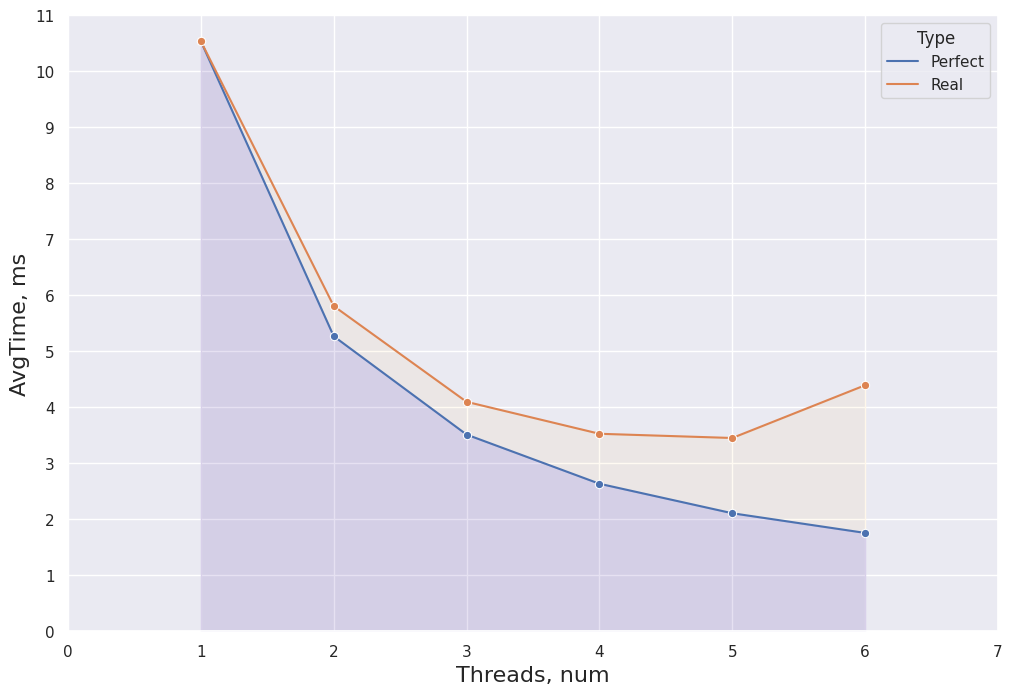

In [12]:
p = sns.lineplot(x="Threads", y="AvgTime", hue="Type", marker="o", data=all_data)
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("AvgTime, ms", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

p.fill_between(x1, y1, color="blue", alpha=0.1)
l2 = p.lines[1]

x2 = l2.get_xydata()[:, 0]
y2 = l2.get_xydata()[:, 1]

p.fill_between(x2, y2, color="orange", alpha=0.05)
p.margins(x=0, y=0)
_ = p.set_xticks(range(0, 8))
_ = p.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7'])
_ = p.set_yticks(range(0, 12))
_ = p.set_yticklabels([str(i) for i in range(0, 12)])

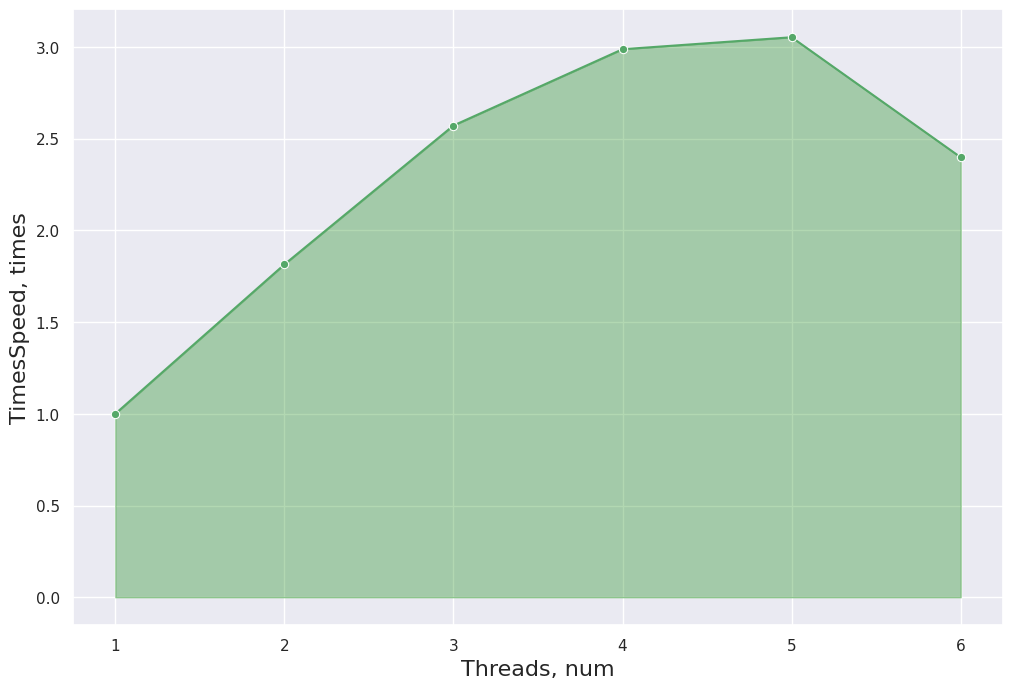

In [13]:
accceleration = [0] * 6
for i in range(0, len(accceleration)):
    accceleration[i] = [saved[i][0], saved[0][1]/saved[i][1]]
a_df = pd.DataFrame(accceleration, columns=["Threads", "TimesSpeed"])
p = sns.lineplot(x="Threads", y="TimesSpeed", marker="o", data=a_df, color='g')
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("TimesSpeed, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.fill_between(x1, y1, color="green", alpha=0.3)

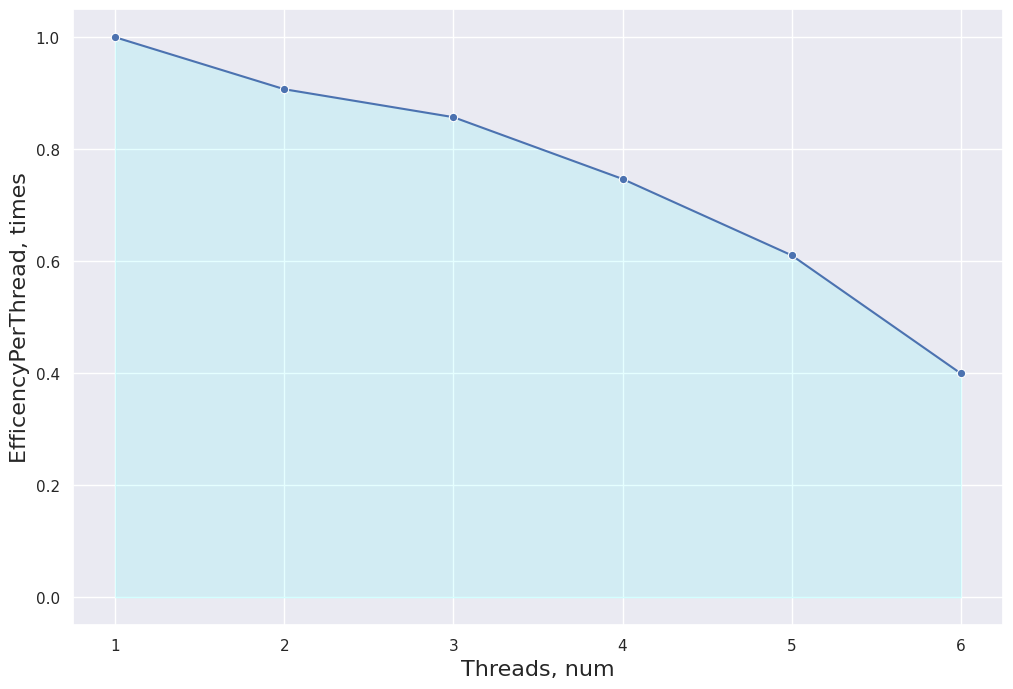

In [14]:
per_thread = [0] * 6
for i in range(0, len(per_thread)):
    per_thread[i] = [accceleration[i][0], accceleration[i][1]/accceleration[i][0]]
thr_df = pd.DataFrame(per_thread, columns=["Threads", "EfficencyPerThread"])
p = sns.lineplot(x="Threads", y="EfficencyPerThread", marker="o", data=thr_df, color='b')
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("EfficencyPerThread, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.fill_between(x1, y1, color="cyan", alpha=0.1)